# 0. Import Packages

In [1]:
#--Basics---------------
import pandas as pd
import numpy as np

#--Data Visualization----
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.decomposition import PCA
from collections import Counter

#---Scikit-Learn--------


#---Misc------------------


# 1. Define Data

## Ian Functions

In [36]:
def numeric_categorical_attributes(data):
    numeric, categorical = (set(), set())
    for col in data.columns:
        try:
            data[col].apply(pd.to_numeric)
            numeric.add(col)
        except:
            categorical.add(col)
    return (numeric, categorical)

## Main

In [6]:
df = pd.read_csv("Amazon Sales FY2020-21.csv")
zip_df = pd.read_csv("us_zip_codes_to_longitude_and_latitude.csv")
zip_dict = {item[0] : (item[1], item[2]) for item in zip(zip_df['Zip'],zip_df['Latitude'], zip_df['Longitude'])}

C:\Users\ianho\AppData\Local\Temp\ipykernel_10216\611987888.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Amazon Sales FY2020-21.csv")


# 2. Data Preparation

## Ian Functions

In [37]:
def clean_out_nulls(data, drop_cols, cols_numeric, cols_categorical):
    # Drop columns that have many nulls.
    result = data.drop(columns=drop_cols, axis=1)
    new_cols_numeric, new_cols_categorical = [cols.difference(drop_cols) for cols in [cols_numeric, cols_categorical]]
    # Impute missing values with the median of the respective column
    for col in new_cols_numeric:
        median_value = data[col].median()
        result[col] = data[col].fillna(median_value)  
    # Impute missing values with the mode of the respective column
    for col in new_cols_categorical:
        result[col] = data[col].fillna(data[col].mode()[0])
    
    return (result, new_cols_numeric, new_cols_categorical)

In [39]:
def remake_column(data, cols_numeric, cols_categorical, col_number, newName, newValues = None, myFunc = None):
    oldName = data.columns[col_number]
    new_data = data.rename(columns = {oldName: newName})
    if newValues is not None:
        oldValues = np.sort(data.loc[:, oldName].unique())
        new_data[newName] = new_data[newName].map(dict(list(zip(oldValues, newValues))))
    else:
        new_data[newName] = new_data[newName].map(myFunc)
    if oldName in cols_numeric:
        cols_numeric = cols_numeric.difference({oldName}).union({newName})
    else:
        cols_categorical = cols_categorical.difference({oldName}).union({newName})
    
    return new_data, cols_numeric, cols_categorical


,Product,Product_ean,Category,Zip Code,Quantity Ordered,Price Each,Cost price,turnover,margin
0,iPhone,5.638009e+12,Clothing,02215,1,700.00,231.0000,700.00,469.0000
1,Lightning Charging Cable,5.563320e+12,Groceries,97035,1,14.95,7.4750,14.95,7.4750
2,Wired Headphones,2.113973e+12,Clothing,94016,2,11.99,5.9950,23.98,11.9900
3,27in FHD Monitor,3.069157e+12,Sports,90001,1,149.99,97.4935,149.99,52.4965
4,Wired Headphones,9.692681e+12,Electronics,73301,1,11.99,5.9950,11.99,5.9950
...,...,...,...,...,...,...,...,...,...
185945,Lightning Charging Cable,6.545974e+12,Electronics,94016,1,14.95,7.4750,14.95,7.4750
185946,AA Batteries (4-pack),5.352480e+12,Electronics,90001,2,3.84,1.9200,7.68,3.8400
185947,Vareebadd Phone,2.674213e+12,Groceries,98101,1,400.00,132.0000,400.00,268.0000
185948,Wired Headphones,5.216304e+12,Groceries,75001,1,11.99,5.9950,11.99,5.9950


## Main

In [7]:
drop_columns = ["order_id", "order_date", "item_id", "sku", "bi_st", "payment_method", "cust_id", "Place Name", "month", "year", "ref_num", 'Name Prefix', "First Name", "Middle Initial", "Last Name", "full_name", "Sign in date", "E Mail", "Sign in date", "Phone No. ", "User Name"]
df = df.drop(columns = drop_columns, axis=1)

In [8]:
for c in df.columns:
  null_count = df.isnull().sum()
  if null_count[c] > 0:
    print(f'Missing Columns in "{c}" with {null_count[c]} missing values')
  if df[c].dtype == 'mixed':
    print(f'Column "{c}" has mixed values')

In [9]:
filter_values = ["complete", "received"]
df = df[df.apply(lambda x: x['status'] in filter_values, axis=1)]
df = df.drop(columns = ['status'], axis = 1)
df = df.reset_index(drop=True)

# 3. Exploratory Analysis

## Nolan Functions

In [11]:
def make_histogram(column):
  data = df[column]
  plt.hist(data)
  plt.title(f'Distribution of {column}')
  plt.show()

## Main

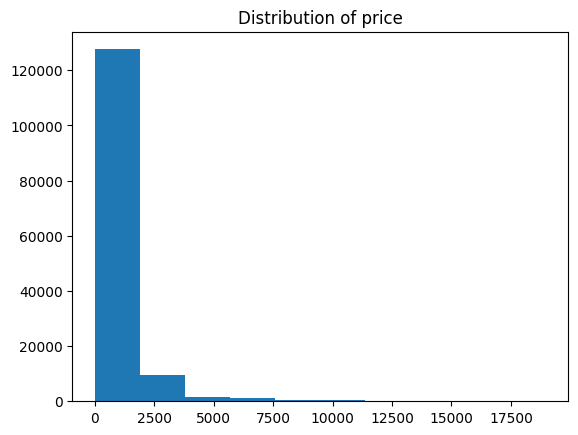

In [12]:
make_histogram('price')

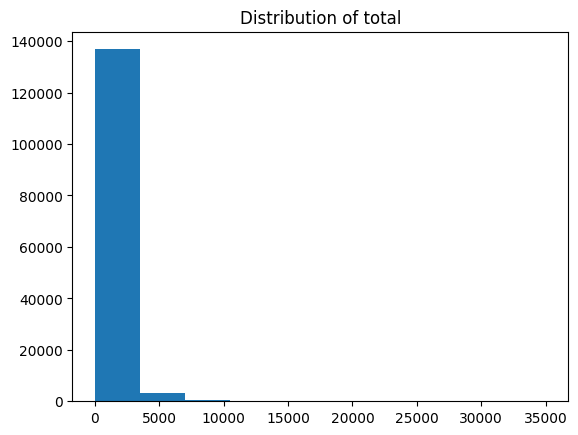

In [13]:
make_histogram('total')

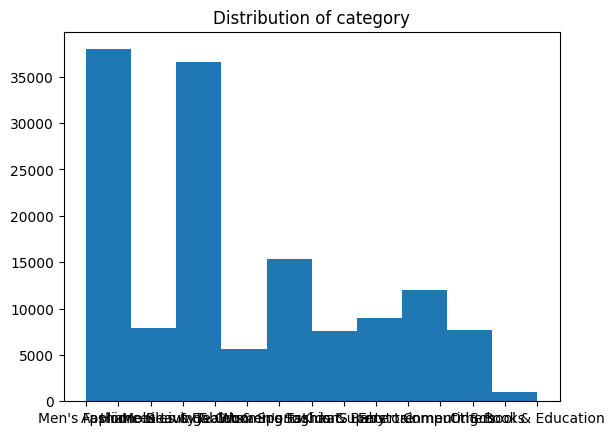

In [14]:
make_histogram("category")

# 4. Encoding

## Nolan Functions

In [15]:
def binary_label_encoding(data, column_name):
    unique_values = list(set(data[column_name]))
    map_value = {unique_values[i] : i for i in range(len(unique_values))}
    data[column_name] = list(map(lambda x : map_value[x], data[column_name]))
    return data

def label_encoding(data, column, values):
    map_values = {values[len(values)-i-1] : i for i in range(len(values)-1, -1, -1)}
    data[column] = list(map(lambda x : map_values[x], data[column]))
    return data

def target_encoding(data, column):
  count_unique = Counter(data[column])
  total = len(data[column])
  df[column] = list(map(lambda x : count_unique[x]/total, df[column]))
  return df

def geoencoding(data):
  lat = []
  lng = []
  drop_rows = []
  count = 0
  zip_list = list(data['Zip'])
  for i in range(len(zip_list)):
    zip_code = zip_list[i]
    if zip_code not in zip_dict:
      drop_rows.append(i)
      continue
    lat_lng = zip_dict[zip_code]

    lat.append(lat_lng[0])
    lng.append(lat_lng[1])
  data = data.drop(drop_rows)
  data = data.reset_index(drop=True)
  data['LAT'] = lat
  data['LNG'] = lng
  return data

## Main

In [16]:
binary_data_columns = ['Gender']
for column_name in binary_data_columns:
    df = binary_label_encoding(df, column_name)

In [17]:
nominal_columns = ["category", "Region"]
# Apply one hot encoding to our dataset for the nominal categorical features
for col in nominal_columns:
    df = pd.get_dummies(df, columns=[col], dtype=int)

In [18]:
target_columns = ["County", "City", "State"]
for t in target_columns:
  df = target_encoding(df, t)

In [19]:
df = geoencoding(df)

# 5. PCA

## Main

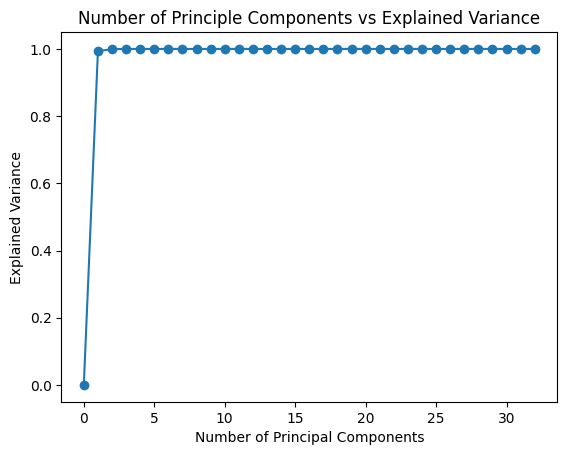

In [21]:
variance_pca = []
number_attributes = len(df.columns)
pca = PCA(n_components=number_attributes)
pca.fit(df)
explained_variance = pca.explained_variance_ratio_
for i in range(1, number_attributes):
    variance_list = list(explained_variance)[:i]
    variance_pca.append(sum(variance_list))
plt.plot([i for i in range(0, number_attributes)], [0] + variance_pca, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance")
plt.title("Number of Principle Components vs Explained Variance")
plt.show()

# 6. Clustering

In [63]:
def makeClusters(df, k):
    X = df[["LAT", "LNG"]]
    kmeans = KMeans(n_clusters=k, n_init="auto").fit(X)
    X = pd.concat([X, pd.Series(data=kmeans.predict(X), name = "Cluster")], axis = 1)
    colors = np.linspace(0, 1, k)
    colordict = dict(zip(range(k), colors))
    X["Color"] = X["Cluster"].map(colordict)
    plt.scatter(x = X["LNG"], y = X["LAT"], c = X["Color"])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Zip Codes in {} Clusters".format(k))
    plt.show()

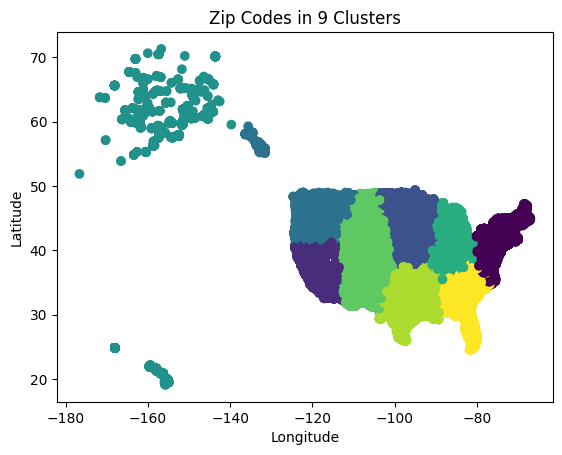

In [65]:
makeClusters(df, 9)